<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/pix2pix/pix2pix/pix2pix_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pix2Pix GAN</b></h1></center>

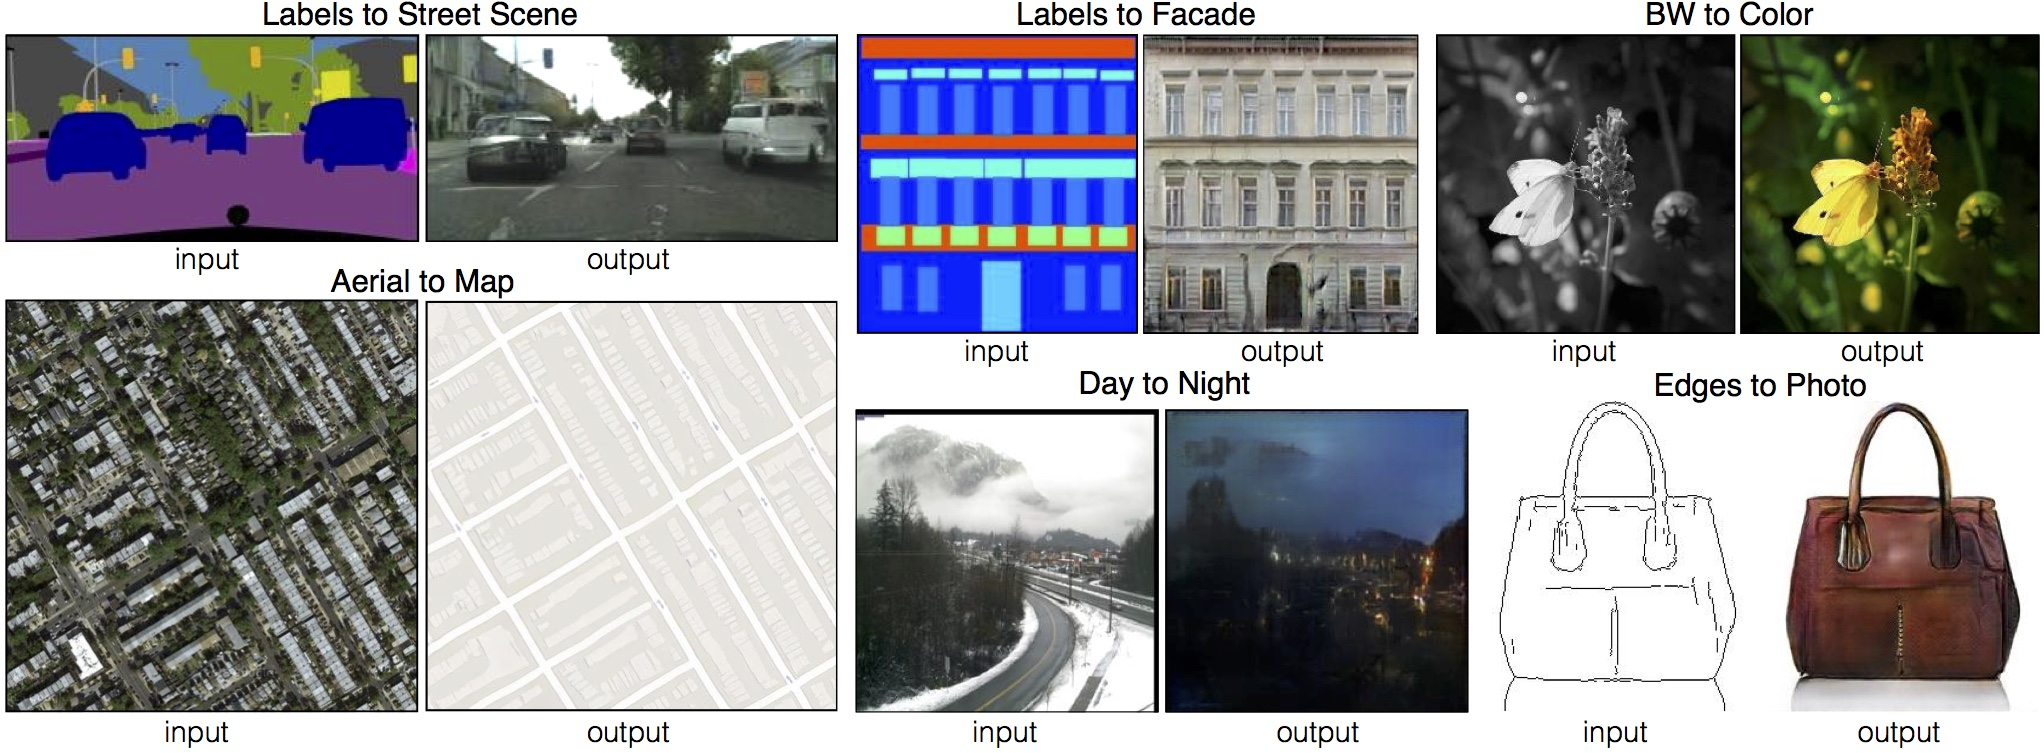

*   Pix2Pix demonstrates image to image translation using Conditional GAN's to learn a mapping from an input image to an output image.

*   Using this technique we can colourize black and white photos, convert google maps to google earth, Super resolution etc.

*   The basic structure of the generator is called an "encoder-decoder" and the structure of the discriminati=or is sililar to the "encoder" part of the generator.



# Downloading the Dataset (Maps)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d vikramtiwari/pix2pix-dataset

In [ ]:
! unzip pix2pix-dataset.zip -d /content/drive/MyDrive/ColabNotebooks/GANs/pix2pix/maps

In [ ]:
!pip install --upgrade albumentations

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import os
from PIL import Image
from tqdm import tqdm

In [2]:
PATH = '/content/drive/MyDrive/ColabNotebooks/GANs/pix2pix/maps/maps/maps'

# Generator

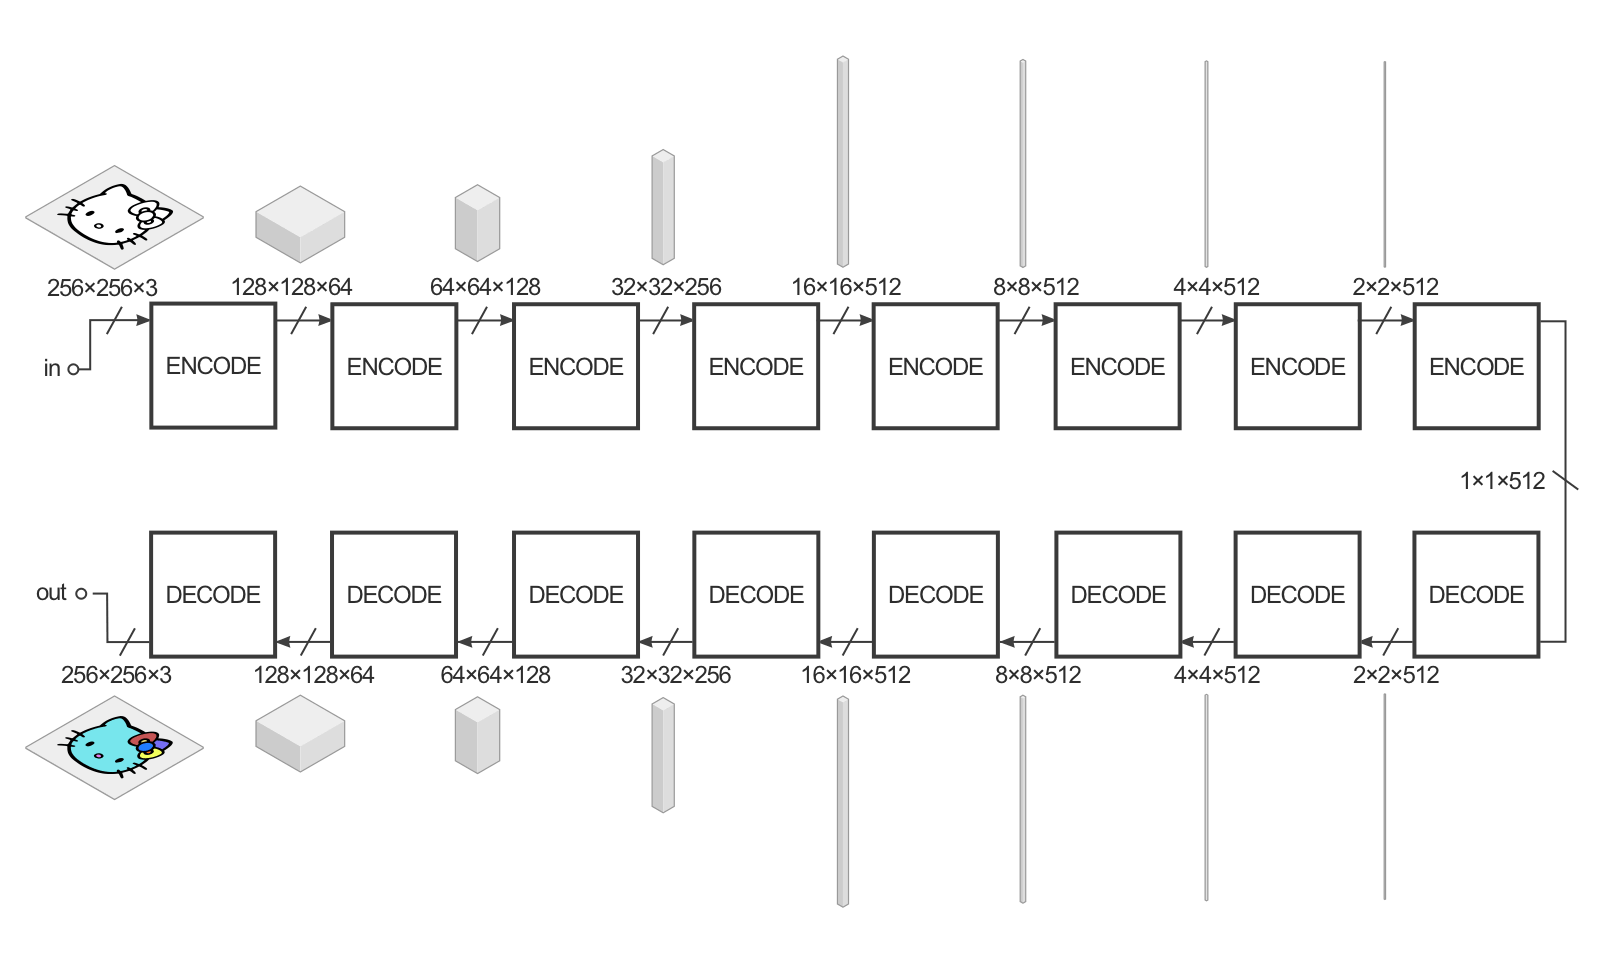

<p>The volumes are there to give you a sense of the shape of the tensor dimensions next to them. The input in this example is a 256x256 image with 3 color channels (red, green, and blue, all equal for a black and white image), and the output is the same.</p>
<br />

<p>The generator takes some input and tries to reduce it with a series of encoders (convolution + activation function) into a much smaller representation. The idea is that by compressing it this way we hopefully have a higher level representation of the data after the final encode layer. The decode layers do the opposite (deconvolution + activation function) and reverse the action of the encoder layers.<p>
<br />

<p>In order to improve the performance of the image-to-image transform in the paper, the authors used a “U-Net” instead of an encoder-decoder. This is the same thing, but with “skip connections” directly connecting encoder layers to decoder layers:</p>

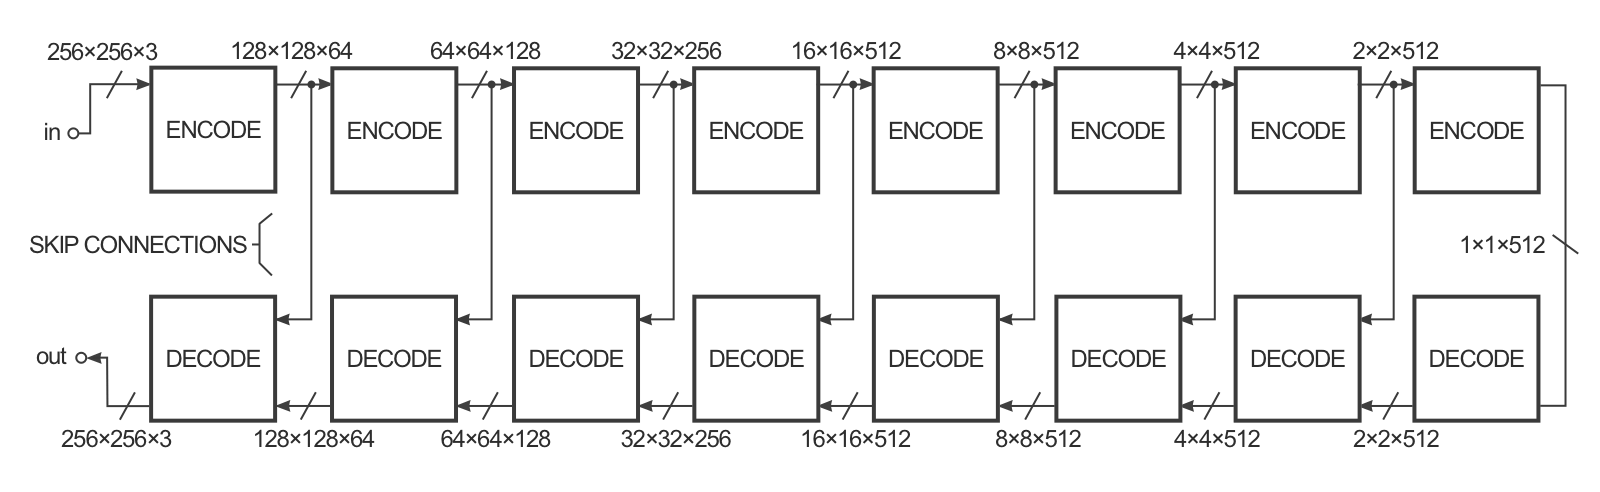

<p>The skip connections give the network the option of bypassing the encoding/decoding part if it doesn’t have a use for it.</p>
<br />

<p>For instance, the first and last layers of the network have no batch norm layer and a few layers in the middle have dropout units.</p>

In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1),
            nn.ReLU()
        )
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        final_up = self.final_up(torch.cat([up7, d1], 1))
        return final_up

In [4]:
gen = Generator(in_channels=3, features=64).to('cuda')
print(gen)

Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

# Descriminator

The Discriminator has the job of taking two images, an input image and an unknown image (which will be either a target or output image from the generator), and deciding if the second image was produced by the generator or not.


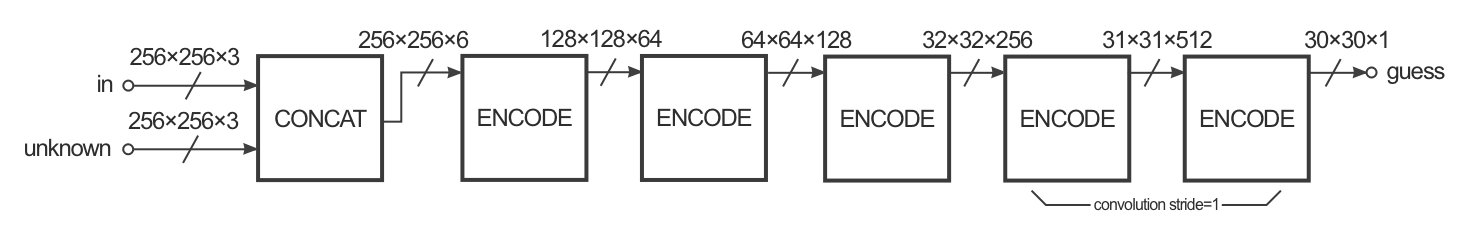

The structure looks a lot like the encoder section of the generator, but works a little differently. The output is a 30x30 image where each pixel value (0 to 1) represents how believable the corresponding section of the unknown image is. In the pix2pix implementation, each pixel from this 30x30 image corresponds to the believability of a 70x70 patch of the input image (the patches overlap a lot since the input images are 256x256). The architecture is called a “PatchGAN”.

In [5]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=2):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.conv(x)

  
class Descriminator(nn.Module):
  def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2),
    )

    layers=[]
    in_channels = features[0]
    for feature  in features[1:]:
      layers.append(
          CNNBlock(in_channels, feature , stride=1 if feature  == features[-1] else 2)
      )
      in_channels = feature 

    layers.append(
        nn.Conv2d(in_channels, 1, kernel_size=4, padding=1, padding_mode='reflect')
    )

    self.model = nn.Sequential(*layers)
  
  def forward(self, x, y):
     x = torch.cat([x, y], dim=1)
     x = self.initial(x)
     x = self.model(x)
     return x

In [6]:
disc = Descriminator(in_channels=3).to('cuda')
print(disc)

Descriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

## Config

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMG_SIZE = 256
CHANNELS = 3
L1_LAMBDA = 100
NUM_EPOCHS = 200
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = '/content/drive/MyDrive/ColabNotebooks/GANs/pix2pix/checkpoint/disc.pth.tar'
CHECKPOINT_GEN = '/content/drive/MyDrive/ColabNotebooks/GANs/pix2pix/checkpoint/gen.pth.tar'

both_transform = A.Compose(
    [
     A.Resize(width=256, height=256), 
     A.HorizontalFlip(p=0.5)
    ],
    additional_targets = {'image0' : 'image'},
)

transform_only_input = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.ColorJitter(p=0.2),
     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
     ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
     A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5 ,0.5], max_pixel_value=255.0),
     ToTensorV2(),
    ]
)

## Utils

In [8]:
def save_some_example(gen, val_loader, epoch, folder):
  x, y = next(iter(val_loader))
  x, y = x.to(DEVICE), y.to(DEVICE)
  gen.eval()
  with torch.no_grad():
    y_fake = gen(x)
    y_fake = y_fake * 0.5 + 0.5
    save_image(y_fake, folder + f"/y_gen_{epoch}.png")
    save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
    if epoch == 1:
      save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
  gen.train()

def save_checkpoint(model, optimizer, path='my_checkpoint.pth.tar'):
  print('=> Saving Checkpoint')
  checkpoint = {
      'state_dict' : model.state_dict(),
      'optimizer' : optimizer.state_dict(),
  }
  try:
    torch.save(checkpoint, path)
  except Exception as e:
    print(e)
  finally:
    print('Checkpoint saved Successfully...!')

def load_checkpoint(checkpoint_file, model, optimizer, lr):
  print('=> Loading Checkpoint')
  checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
  try:
    model.load_state_dict(checkpoint['state_dict'])
  except exception as e:
    print(e)
  finally:
     print('Model Loaded Successfully')
  optimizer.load_state_dict(checkpoint['optimizer'])

  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

# Dataset 

In [9]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image

# Training

<u>**Training the generator:**</u>
<br />
<p>To train the discriminator, first the generator generates an output image. The discriminator looks at the input/target pair and the input/output pair and produces its guess about how realistic they look. The weights of the discriminator are then adjusted based on the classification error of the input/output pair and the input/target pair.</p>
<br />

<p>The generator’s weights are then adjusted based on the output of the discriminator as well as the difference between the output and target image.</p>

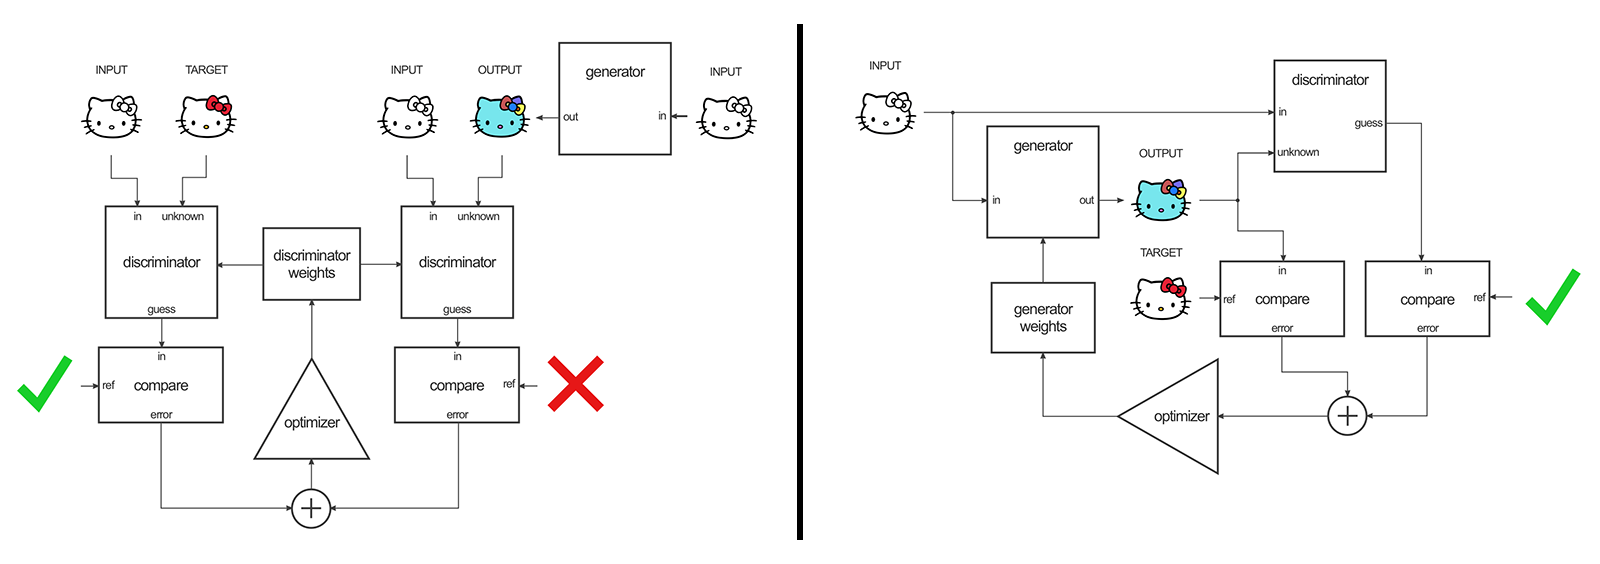

In [ ]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scalar, d_scalar):
  loop = tqdm(loader, leave=True)
  
  for idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)

    # Train Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x, y)
      D_real_loss = bce(D_real, torch.ones_like(D_real))
      D_fake = disc(x, y_fake.detach())
      D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
      D_loss = (D_real_loss + D_fake_loss) / 2

    disc.zero_grad()
    d_scalar.scale(D_loss).backward()
    d_scalar.step(opt_disc)
    d_scalar.update()

    # Train Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(x, y_fake)
      G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
      L1 = l1(y_fake, y) * L1_LAMBDA
      G_loss = G_fake_loss + L1

    opt_gen.zero_grad()
    g_scalar.scale(G_loss).backward()
    g_scalar.step(opt_gen)
    g_scalar.update()

def main():
  disc = Descriminator(in_channels=3).to(DEVICE)
  gen = Generator(in_channels=3, features=64).to(DEVICE)
  opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
  opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
  BCE = nn.BCEWithLogitsLoss()
  L1_LOSS = nn.L1Loss()

  if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
    
  train_dataset = MapDataset(root_dir=os.path.join(PATH, 'train'))
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
 
  g_scalar = torch.cuda.amp.GradScaler()
  d_scalar = torch.cuda.amp.GradScaler()

  val_dataset = MapDataset(root_dir=os.path.join(PATH, 'val'))
  val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

  
  for epoch in range(NUM_EPOCHS):
    train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scalar, d_scalar)

    if SAVE_MODEL and epoch % 5 == 0:
      save_checkpoint(gen, opt_gen, CHECKPOINT_GEN)
      save_checkpoint(disc, opt_disc, CHECKPOINT_DISC)

    save_some_example(gen, val_loader, epoch, folder='/content/drive/MyDrive/ColabNotebooks/GANs/pix2pix/evaluation')

if __name__ == '__main__':
  main()

  0%|          | 0/69 [00:00<?, ?it/s]